In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

**Define Tickers and Time ranges**

Define the list of tickers

In [2]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

Set the end date to today

In [3]:
end_date = datetime.today()

Set the satrt date to 5 years ago

In [4]:
start_date = end_date - timedelta(days = 5 * 365)
print(start_date)

2020-03-31 07:41:36.264650


**Download adjusted close prices**

Create an empty DataFrame to store the adjusted close prices

In [5]:
adj_close_df = pd.DataFrame()

In [6]:
for ticker in tickers:
  data = yf.download(ticker, start = start_date, end = end_date)
  adj_close_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
  adj_close_df[ticker] = data[adj_close_col]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Display the dataframe

In [7]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2020-03-31  239.650574  74.233727  148.050003  184.773239  119.647011
2020-04-01  228.865143  74.617287  149.449997  176.922318  114.124557
2020-04-02  234.146317  74.965958  151.899994  180.512985  116.500603
2020-04-03  230.761917  74.931107  152.649994  177.951035  114.514374
2020-04-06  246.261276  75.166435  156.880005  190.673538  122.524284
...                ...        ...         ...         ...         ...
2025-03-24  574.080017  73.000000  277.250000  490.660004  283.015045
2025-03-25  575.460022  73.089996  278.470001  493.459991  283.493317
2025-03-26  568.590027  72.930000  278.239990  484.380005  280.175018
2025-03-27  567.080017  72.900002  281.970001  481.619995  278.989990
2025-03-28  555.659973  73.320000  284.059998  468.940002  273.429993

[1256 rows x 5 columns]


**calculate the lognoramal returns**

calculate the lognormal returns for each ticker

In [8]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

Drop missing values

In [9]:
log_returns = log_returns.dropna()

**Calculate the covariance matrix**

Calculate the covarialnce matrix using annualized log returns

In [10]:
cov_matrix = log_returns.cov() * 252

In [11]:
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.030686  0.001800  0.004095  0.037437  0.031473
BND  0.001800  0.003470  0.003175  0.002645  0.001894
GLD  0.004095  0.003175  0.022074  0.005857  0.004256
QQQ  0.037437  0.002645  0.005857  0.053516  0.038353
VTI  0.031473  0.001894  0.004256  0.038353  0.032627


**Define portfolio performance metrics**

Portfolio standard deviation

This line of code calculates the portfolio variance, which is a measure associated witha portfolio of assets.b It represents the combined volatility of the assets in the portfolio, taking intop account their individual volatailities and corelations with each other.

In [12]:
def standard_deviation(weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

Calculate the expected returns

key assumption : Expected returns are based on the historical returns

In [13]:
def expected_returns(weights, log_returns):
  return np.sum(log_returns.mean() * weights)*252

Calculate the sharpe ratio

In [14]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return (expected_returns(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

**Portfolio Optimization**

Set the risk-free rate

In [15]:
!pip install fredapi

In [16]:
from fredapi import Fred

fred = Fred(api_key = '1a070069842ebd4c98d6effe4a28f1d7')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

# SET THE RISK FREE RATE
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.044500000000000005


**Define the function ot minimize(negative sharpe ratio)**

In [17]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Set the constraints and bounds

Constraints are conditions tht must be met by the solution during the optimization process. In this case the constraint is sum of all portfolio weights must be equal to 1. The constraints variable is a dictionary with 2 keys : 'type' and 'fun'.

'type' is set to 'eq' which means "equality costraint", and 'fun' is assigned in the fucntion check_sujm, which checks if the sum of the portfolio weigfhts equals 1.

Bounds are limits placed on the variable sduring the optimization process. In this case, the variables are the portfolio weights and each weight should be between 0 and 1.


In [18]:
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

Set the initial weights

In [19]:
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


**Optimzie the weights to maximize the sharpe ratio**

'SLSQP' stands for Sequential Least Square Quadratic Programming, which is a numerical optimizatio technique suitable for solving non linear optimization problems with constraints.

In [20]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate),
                            method = 'SLSQP', bounds = bounds, constraints = constraints)

Get optimal weights

In [21]:
optimal_weights = optimized_results.x

**Analyze the optimal portfolio**

Display analytics of the optimal portfolio

In [22]:
print("OPTIMAL WEIGHTS : ")
for ticker, weight in zip(tickers, optimal_weights):
  print(f"{ticker}: {weight * 100:.2f}%")

print()

optimal_portfolio_return = expected_returns(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return * 100:.2f}%")
print(f"Annual Volatility: {optimal_portfolio_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.2f}")

OPTIMAL WEIGHTS : 
SPY: 50.00%
BND: 0.00%
GLD: 49.33%
QQQ: 0.00%
VTI: 0.67%

Expected Annual Return: 15.01%
Annual Volatility: 12.37%
Sharpe Ratio: 0.85


**Display the final portfolio in plot**

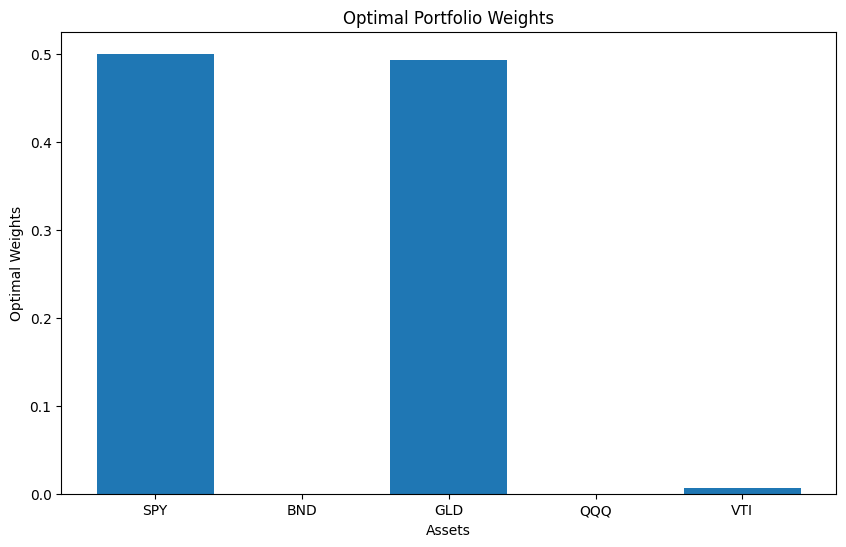

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show()